In [1]:
MODELS = [
    
]

ITERATIONS_TO_TEST = [
    1
]

NUM_PROCS = 4
GAMES_PER_CONFIG = 10

In [2]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
import torch
torch.set_num_threads(1)
from train import load_from_checkpoint, test_network
import torch.multiprocessing as mp
from resnet import ResNet2Heads
from copy import deepcopy
from utils import input_to_tensor_scalar
import time
import warnings
import csv

In [3]:
model_results = dict()

/Users/marshingjay/Downloads/resnet64_ep1000-2.pt 1


/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_62dm4livko/croot/pytorch_1675190252673/work/aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,
/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_62dm4livko/croot/pytorch_1675190252673/work/aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,
/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modu

score=596.0, moves=82, high_square=6, trial_num=1
score=580.0, moves=80, high_square=6, trial_num=2
score=1104.0, moves=121, high_square=7, trial_num=3
score=1712.0, moves=174, high_square=7, trial_num=4
score=1224.0, moves=127, high_square=7, trial_num=5
score=1008.0, moves=107, high_square=7, trial_num=6
score=2768.0, moves=240, high_square=8, trial_num=7
score=1300.0, moves=135, high_square=7, trial_num=8
score=656.0, moves=93, high_square=6, trial_num=9
score=904.0, moves=99, high_square=7, trial_num=10
took 4.736548185348511
/Users/marshingjay/Downloads/resnet64_ep1000-2.pt 2


/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_62dm4livko/croot/pytorch_1675190252673/work/aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,
/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_62dm4livko/croot/pytorch_1675190252673/work/aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,
/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modu

score=712.0, moves=92, high_square=6, trial_num=1
score=1020.0, moves=126, high_square=6, trial_num=2
score=1992.0, moves=201, high_square=7, trial_num=3
score=1736.0, moves=175, high_square=7, trial_num=4
score=1988.0, moves=165, high_square=8, trial_num=5
score=676.0, moves=94, high_square=6, trial_num=6
score=1488.0, moves=155, high_square=7, trial_num=7
score=3188.0, moves=261, high_square=8, trial_num=8
score=440.0, moves=69, high_square=5, trial_num=9
score=728.0, moves=96, high_square=6, trial_num=10
took 6.86165714263916
/Users/marshingjay/Downloads/resnet64_ep2000-2.pt 1


/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_62dm4livko/croot/pytorch_1675190252673/work/aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,
/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_62dm4livko/croot/pytorch_1675190252673/work/aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,
/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modu

score=724.0, moves=95, high_square=6, trial_num=1
score=684.0, moves=90, high_square=6, trial_num=2
score=984.0, moves=105, high_square=7, trial_num=3
score=2040.0, moves=191, high_square=7, trial_num=4
score=772.0, moves=95, high_square=6, trial_num=5
score=1160.0, moves=119, high_square=7, trial_num=6
score=1288.0, moves=131, high_square=7, trial_num=7
score=1508.0, moves=152, high_square=7, trial_num=8
score=664.0, moves=89, high_square=6, trial_num=9
score=2680.0, moves=217, high_square=8, trial_num=10
took 5.187170028686523
/Users/marshingjay/Downloads/resnet64_ep2000-2.pt 2


/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_62dm4livko/croot/pytorch_1675190252673/work/aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,
/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_62dm4livko/croot/pytorch_1675190252673/work/aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,
/Users/marshingjay/miniconda3/envs/python3/lib/python3.8/site-packages/torch/nn/modu

score=288.0, moves=58, high_square=4, trial_num=1
score=1248.0, moves=129, high_square=7, trial_num=2
score=1544.0, moves=165, high_square=7, trial_num=3
score=1684.0, moves=172, high_square=7, trial_num=4
score=632.0, moves=87, high_square=6, trial_num=5
score=1772.0, moves=173, high_square=7, trial_num=6
score=1484.0, moves=155, high_square=7, trial_num=7
score=2840.0, moves=234, high_square=8, trial_num=8
score=2252.0, moves=218, high_square=7, trial_num=9
score=740.0, moves=98, high_square=6, trial_num=10
took 7.399557828903198


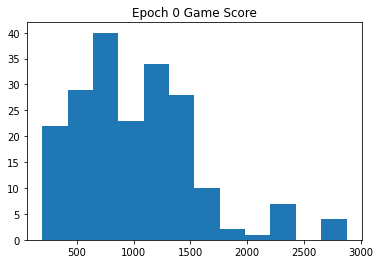

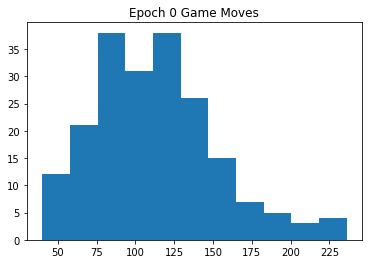

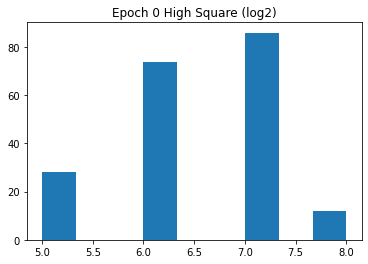

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for model_path in MODELS:
        _, model, _, hyperparameters, _, _, _ = load_from_checkpoint(model_path, ResNet2Heads, load_replay_memory=False)
        csv_filename = f'benchmark_results_{model_path.split("/")[-1][:-3]}.csv'
        trials = 0
        def write_trial_results(results):
            _, moves, high_square, score = results
            with open(csv_filename, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([moves, high_square, score, iter_qty])
            global trials
            trials += 1
            print(f'score={score}, moves={moves}, high_square={high_square}, trial_num={trials}')

        for iter_qty in ITERATIONS_TO_TEST:
            trials = 0
            print(model_path, iter_qty)
            hyperparameters.num_mcts_test_evals = iter_qty
            start_time = time.time()
            with mp.Pool(NUM_PROCS) as pool:
                results = []
                for _ in range(GAMES_PER_CONFIG):
                    results.append(pool.apply_async(test_network, (model, hyperparameters, input_to_tensor_scalar, ), callback=write_trial_results, error_callback=print))
                for r in results:
                    r.wait()
            print(f'took {time.time() - start_time}')
